In [0]:
###########################################################################
# ResNet50 - mixup(CIFAR-10、CIFAR10)
###########################################################################
# 参考
# https://qiita.com/yu4u/items/70aa007346ec73b7ff05


In [1]:
#==============================================================
# 1.インポート・宣言
#==============================================================

import keras
import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc import toimage
from PIL.Image import fromarray as toimage
from keras.datasets import cifar10
from keras.utils import np_utils

from keras import backend as K
from keras.layers import Layer

from keras.callbacks import EarlyStopping


from keras.callbacks import LearningRateScheduler
from keras.layers import Input

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50


######
# Parameters
EPOCHS=5
BATCH_SIZE=128



Using TensorFlow backend.


In [0]:
#==============================================================
# 2.画像のダウンロード
#==============================================================
# CIFAR-10 の画像をロードする
# 普通はネットからダウンロードしてきてそれを読み込むのだが、
# KerasではCIFAR10をダウンロードしてきて読み込むところまでを
# やってくれる機能があるのでそれを使っている
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# CIFAR-10の教師データは 0 ～ 9 までの数字になっているが、これだと人はわかりにくいので
# 0 → airplane, 1 → automobile…のような対応関係を配列で持っておく
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])


(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


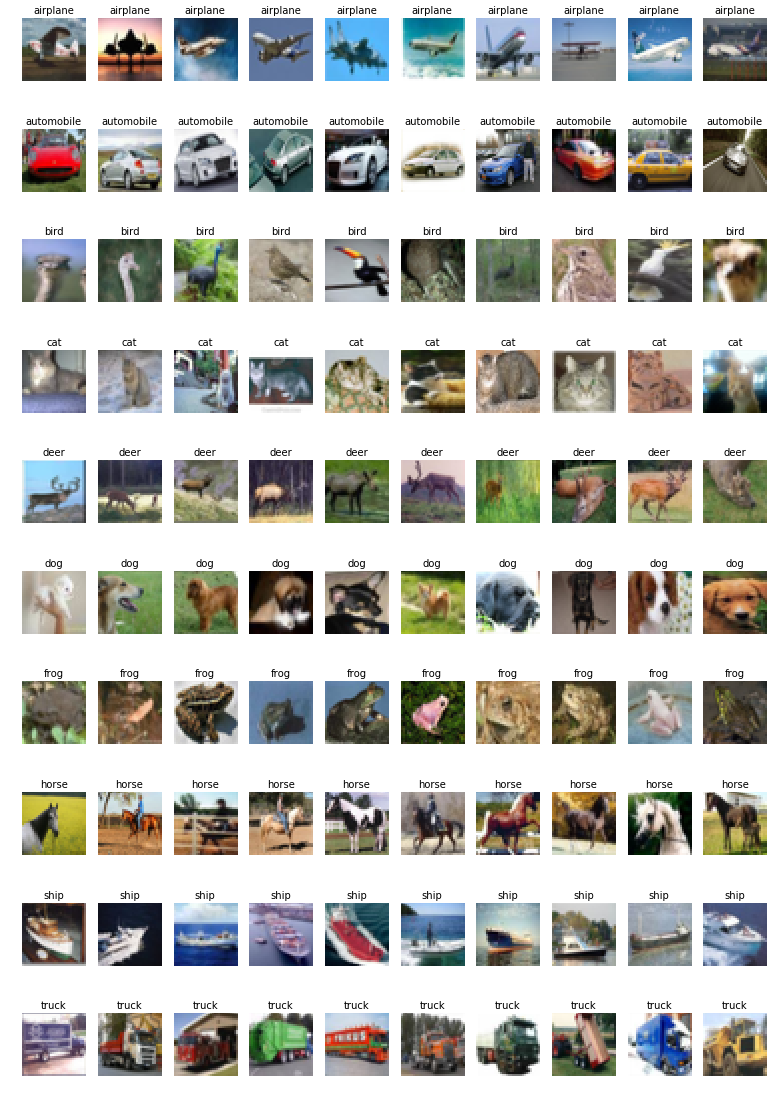

In [3]:
#==============================================
# 3.事前のデータ確認
#==============================================


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

nclasses = 10
pos = 1
# w16,h24のエリアに描画する。
plt.figure(figsize=(16,24), dpi=60)

# matplotlib で学習用画像を10個ずつ表示する
# matplotlib はグラフを表示するためのライブラリでものすごく多機能なため、
# 便利ではあるがかなりとっつきづらい
# 細かい説明はキリがないので興味があれば調べてみてほしい。
# クラス毎にループを回す(0～9)
for targetClass in range(nclasses):
    targetIdx = []
    for i in range(len(y_train)):
        if y_train[i][0] == targetClass:
            # 対応するクラスのy_trainのインデックスを保持する
            targetIdx.append(i)

    # 配列をランダムに並べ変える
    np.random.shuffle(targetIdx)
    # クラス内の先頭10個だけ選んで表示
    for idx in targetIdx[:10]:
        # X_train[idx] は3次元の行列になっており、そのままだと数字の羅列が表示されるだけなので
        # toimage を使って画像に変換してから表示する
        img = toimage(X_train[idx])
        
        # 縦10×横10ファイル数を表示
        plt.subplot(10, 10, pos)
        plt.imshow(img)
        plt.axis('off')
        # タイトルにラベルを表示
        plt.title(cifar10_labels[y_train[idx][0]])
        pos += 1

plt.show()


In [0]:
#==============================================
# 4.データ変換
#==============================================

# floatに変換しておく
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 正規化
X_train /= 255.0
X_test /= 255.0

# one-hot vector に変換したほうが都合が良い
# たとえば 4 ではなくて [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] のようなデータにする
# ##ラベルに距離の属性を持たせなくて済む！！！
# こうしないとクラス分類ではなくて回帰として扱われてしまいうまくいかない
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)


In [5]:
#==============================================================
# 5.mixup Generator
#==============================================================
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        _, class_num = self.y_train.shape
        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])

        return X, y

#########

# trainデータをさらに、train用とvalidate用に分ける。

(X_train_train, X_train_test, Y_train_train, Y_train_test) = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

print(X_train_train.shape, Y_train_train.shape)
print(X_train_test.shape, Y_train_test.shape)


datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

training_generator = MixupGenerator(X_train_train, Y_train_train, BATCH_SIZE , datagen=datagen)()


(40000, 32, 32, 3) (40000, 10)
(10000, 32, 32, 3) (10000, 10)


In [6]:
#==============================================================
# 6.ResNet50 モデル構築
#==============================================================
def resnet50():
  # 入力テンソルを定義しておく
  # 画像のサイズ(h,w,チャネル数(RGBで3))
  inputs = Input(shape=(32, 32, 3))

  # ResNet50
  model = ResNet50(weights=None, include_top=True, input_tensor=inputs, classes=10)
  
  # 重み全部上書きする
  for layer in model.layers: 
      layer.trainable = True
   
  return model
  
######
model = resnet50()
model.compile('Adam', 'categorical_crossentropy', metrics=['accuracy'])

model.summary()


W0630 11:31:50.139932 140516952717184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 11:31:50.182840 140516952717184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 11:31:50.200525 140516952717184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0630 11:31:50.249266 140516952717184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0630 11:31:50.251028

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
#==============================================================
# 7.学習
#==============================================================

# 1 epoch ごとに val_acc　に変化があるか調べて、殆ど変わってなかったら学習を打ち切る
# ★過学習したときにモデルを止める！！validationのaccuracyがpatience:2回まで我慢する。
#   mode は上がる下がると良いのかをします。autoだと自動で判断する。
#   verbose=1でプリントしてくれる。
#   val_acc:バリデーションデータセットの精度
callback_es = EarlyStopping(monitor='val_acc', patience=2, mode='auto', verbose=1)


h = model.fit_generator(generator=training_generator,
                    steps_per_epoch=X_train_train.shape[0] // BATCH_SIZE,
                    validation_data=(X_train_test, Y_train_test),
                    epochs=EPOCHS, verbose=1,
                    callbacks=[callback_es])



W0630 11:31:58.777120 140516952717184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
312/312 [==============================] - 129s 413ms/step - loss: 2.1735 - acc: 0.3049 - val_loss: 14.5289 - val_acc: 0.0986
Epoch 2/5
312/312 [==============================] - 104s 332ms/step - loss: 1.8178 - acc: 0.3952 - val_loss: 1.9060 - val_acc: 0.4302
Epoch 3/5
312/312 [==============================] - 102s 328ms/step - loss: 1.6544 - acc: 0.4627 - val_loss: 1.5633 - val_acc: 0.4811
Epoch 4/5
312/312 [==============================] - 103s 330ms/step - loss: 1.6758 - acc: 0.4644 - val_loss: 1.8073 - val_acc: 0.3339
Epoch 5/5
312/312 [==============================] - 102s 327ms/step - loss: 1.8765 - acc: 0.4070 - val_loss: 2.2309 - val_acc: 0.2009
Epoch 00005: early stopping


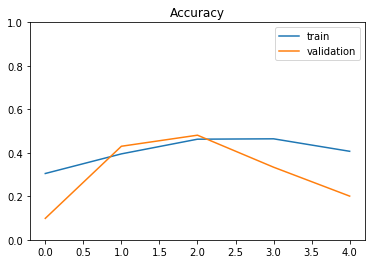

In [8]:
#==============================================================
# 8.精度のプロット
#==============================================================

# 0 ～ len(h.history['acc'])-1 の等差数列
epoch = np.arange(len(h.history['acc']))
# <class 'numpy.ndarray'>
# 例)epoch = [0 1 2 3 4 5]

# accuracy と validation accuracy の推移をプロットする
plt.title('Accuracy')
# y軸の範囲0.0～1.0
plt.ylim(0.0, 1.0)

#・h.historyの例:
#  {'val_loss': [1.648613947033882, ・・・],
#   'val_acc': [0.4728000000119209, ・・・],
#   'loss': [1.3863265740126371, ・・・],
#   'acc': [0.5063250005198643, ・・・]}

# x軸：epoch数、y軸:h.history['acc'],凡例:train
plt.plot(epoch, h.history['acc'], label='train')

# x軸：epoch数、y軸:h.history['val_acc'],凡例:validation
plt.plot(epoch, h.history['val_acc'], label='validation')

# 凡例をグラフ上に出す
plt.legend()
plt.show()


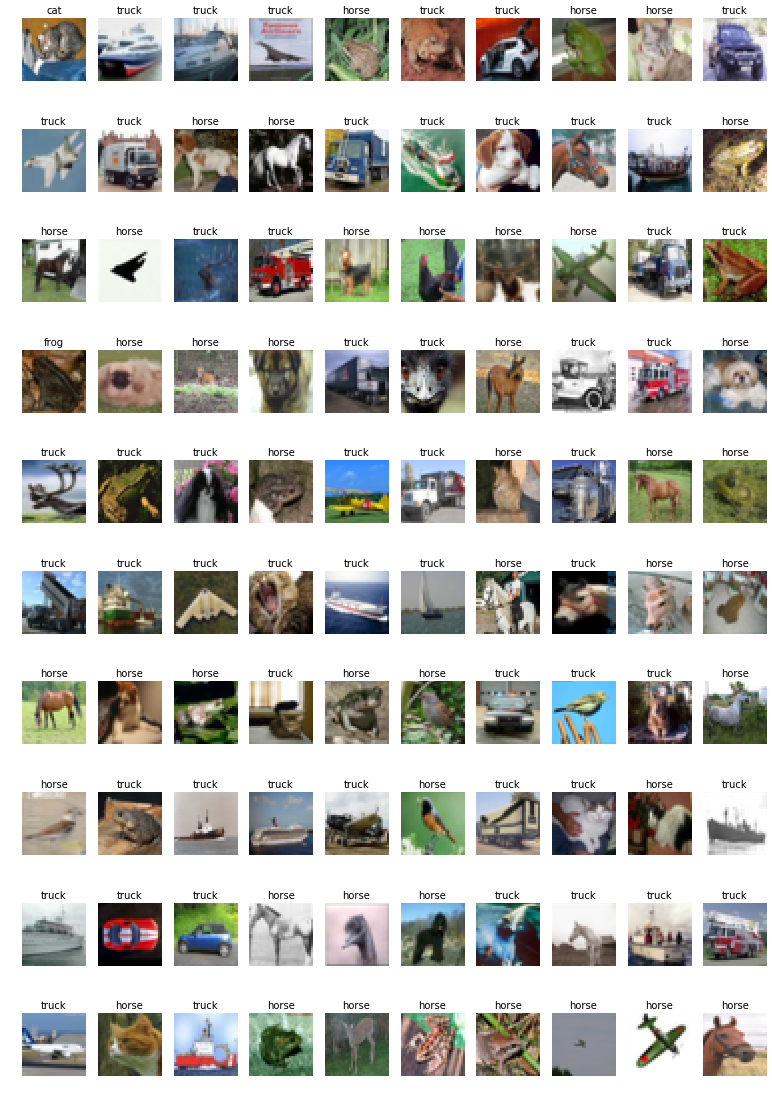

In [9]:
#==============================================================
# 9.作ったモデルで実行
#==============================================================

results = model.predict(X_test)
##<class 'numpy.ndarray'>
##(10000, 10)
## 縦方向(↓):10000個、横方向(→)：10個
##例)
##[[9.3436189e-02 4.3639988e-03 1.2936866e-03 ... 3.6223274e-02
##  3.3119796e-03 3.1835388e-04]
## [6.4462284e-03 1.4985842e-04 2.2184736e-06 ... 2.4948406e-09
##  9.9338913e-01 1.2444694e-05]
## [5.8614958e-02 9.3148870e-04 1.7577963e-03 ... 7.5326279e-05
##  9.2667145e-01 1.1901227e-02]
## ...
## [1.4164560e-06 3.3334450e-06 2.0431653e-01 ... 7.9179788e-03
##  1.7957157e-04 2.1580227e-05]
## [6.8654412e-01 2.5796095e-01 3.7540432e-02 ... 1.4178273e-05
##  1.9961278e-04 7.5550493e-06]
## [8.2166589e-06 1.0961240e-06 3.4247626e-06 ... 9.8534459e-01
##  4.4454353e-07 2.3437798e-07]]

# X_testは正規化(つまり0～1)されているので、描画のために解除する。

# 正規化解除
X_test *= 255.0

# intに変換しておく
X_test = X_test.astype('uint8')


pos = 1
# w16,h24のエリアに描画する。
plt.figure(figsize=(16,24), dpi=60)

# 100個描画するループ
for i in range(100):
  # 3次元の数値の行列を画像に変換
  img = toimage(X_test[i])

  # 値が最大の配列のindexを取得
  label = results[i].argmax()
  # 縦10×横10ファイル数を表示
  plt.subplot(10, 10, pos)
  plt.imshow(img)
  plt.axis('off')
  # ラベル文字列をタイトルとして表示
  plt.title(cifar10_labels[label])
  pos += 1        

# 定性分析するため、実際に表示してみる
# 効率よくやるには正解/不正解も出す。
plt.show()

